In [12]:
# Importing libraries
import numpy as np
from imageio import imread
from scipy import ndimage
from scipy import signal
from numpy import linalg as LA
import matplotlib.pyplot as plt
from skimage import filters


In [13]:
# 1. Random Mask
def RandomMask(x, f):
    m = np.ones((x.shape[0],x.shape[1]))
    xBar = np.copy(x)
    pix = round(m.size*f/100)
    
    for i in range(0,pix):
        loc0 = np.random.randint(m.shape[0])
        loc1 = np.random.randint(m.shape[1])
        changed = False
            
        while changed == False:
            loc0 = np.random.randint(m.shape[0])
            loc1 = np.random.randint(m.shape[1])

            if m[loc0, loc1] == 1:
                m[loc0, loc1] = 0
                xBar[loc0, loc1] = 0
                changed = True
    
    return xBar, m


In [14]:
# 2. ImageGrad
def ImageGrad(x):
    gMag = filters.sobel(x)
    return gMag


In [15]:
# 3. ReconLoss
def ReconLoss(xRecon, xBar, m, lam):
    # lambda*||grad(xRecon)||1
    grad_xRecon = ImageGrad(xRecon)
    
    onenorm = LA.norm(grad_xRecon, 1)
    reg = lam*onenorm

    # ||m*xRecon-xBar||2^2
    mRecon = m*xRecon
    difference = mRecon-xBar
    twonorm = LA.norm(difference, 2)
    twonormsq = twonorm*twonorm

    # ||m*xRecon-xBar||2^2 - ||grad(xRecon)||1
    loss = twonormsq+reg
    
    return loss    


In [16]:
# 4. ImageMerge
def ImageMerge(x1, x2, alpha):
    x1_alpha = alpha*x1
    x2_alpha = (1-alpha)*x2
    return x1_alpha+x2_alpha


In [17]:
# 5. ImageMergeWithMask
def ImageMergeWithMask(x1, x2, m, alpha):
    return (m*x1) + (1-m)*(alpha*x1 + (1-alpha)*x2)
    

In [18]:
# Loading X.png and Y.png
x = imread('X.png').astype('float32')
y = imread('Y.png').astype('float32')

# Creating masked image for analysis
f=10
xBar, m = RandomMask(x, f)

lam = 20


Minimum loss: 139185.01216379786. Alpha of min loss: 1.0


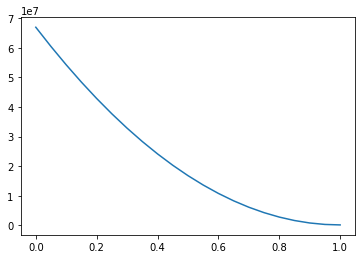

In [19]:
# 6. Recon Loss compared to alpha: ImageMerge

# Creating reconstructed image for different values of alpha
num = 21
alphas = np.linspace(0.0, 1.0, num)
mergeLosses = np.zeros((num, 1))
mergeImages = np.zeros((x.shape[0], y.shape[0], num))

for i in range(0,num):
    mergeImages[:,:,i] = ImageMerge(x, y, alphas[i])
    # Calculating loss of reconstructed image
    mergeLosses[i] = ReconLoss(mergeImages[:,:,i], xBar, m, lam)

plt.plot(alphas, mergeLosses)

print('Minimum loss: '+str(np.amin(mergeLosses))+'. Alpha of min loss: '+str(alphas[np.argmin(mergeLosses)]))
mergeMinLossLoc = np.argmin(mergeLosses)


Minimum loss: 136299.92633590818. Alpha of min loss: 0.65


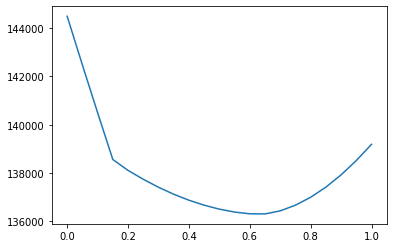

In [23]:
# 7. Recon Loss compared to alpha: ImageMergewithMask

# Creating reconstructed image for different values of alpha
num = 21
alphas = np.linspace(0.0, 1.0, num)
mergeMaskLosses = np.zeros((num, 1))
mergemaskImages = np.zeros((x.shape[0], x.shape[1], num))

for i in range(0,num):
    mergemaskImages[:,:,i] = ImageMergeWithMask(x, y, m, alphas[i])
    # Calculating loss of reconstructed image
    mergeMaskLosses[i] = ReconLoss(mergemaskImages[:,:,i], xBar, m, lam)

plt.plot(alphas, mergeMaskLosses)

print('Minimum loss: '+str(np.amin(mergeMaskLosses))+'. Alpha of min loss: '+str(alphas[np.argmin(mergeMaskLosses)]))
mergemaskMinLossLoc = np.argmin(mergeMaskLosses)


Text(0.5, 0, 'Alpha = 0.65. Loss = [136299.92633591]')

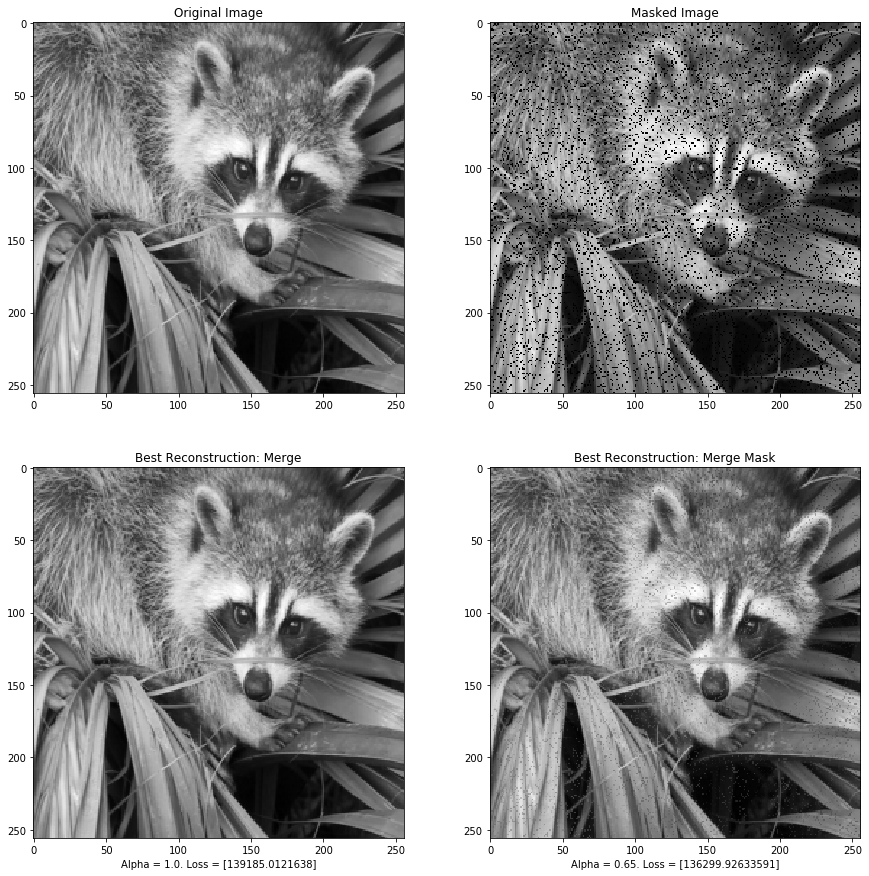

In [24]:
# 8.
fig = plt.figure(figsize=(15,15))

plt.gray()

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.imshow(x)
ax2.imshow(xBar)
ax3.imshow(mergemaskImages[:,:,mergeMinLossLoc])
ax4.imshow(mergemaskImages[:,:,mergemaskMinLossLoc])

ax1.set_title("Original Image")
ax2.set_title("Masked Image")
ax3.set_title("Best Reconstruction: Merge")
ax4.set_title("Best Reconstruction: Merge Mask")

ax3.set_xlabel("Alpha = "+str(alphas[mergeMinLossLoc])+". Loss = "+str(mergeLosses[mergeMinLossLoc]))
ax4.set_xlabel("Alpha = "+str(alphas[mergemaskMinLossLoc])+". Loss = "+str(mergeMaskLosses[mergemaskMinLossLoc]))

In [11]:
# The best reconstruction, according to our Reconstruction loss function, is the 
# Image Merged With Mask at an alpha of 0.45. This image, to have a smaller loss than
# the merged image with an alpha of 1 (which is just the original image) because
# our regularization function prioritizes images with a smaller gradient, therefore 
# the magnitude of the gradient must be smaller than that of the original image which
# creates a lower overall loss value